In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import pickle

In [5]:
DATA_PATH = "/home/stefan/Documents/Workspace/Python/ML/Hackathon/eco-forecast/data"
MODEL_PATH = "/home/stefan/Documents/Workspace/Python/ML/Hackathon/eco-forecast/models"

df = pd.read_csv(f'{DATA_PATH}/processed_data.csv')

In [192]:
df.shape

(8760, 29)

In [193]:
countries = [col.split('_')[2] for col in df.columns if 'green_energy' in col]

In [194]:
df.columns

Index(['StartTime', 'green_energy_SE', 'SE_Load', 'green_energy_DE', 'DE_Load',
       'green_energy_HU', 'HU_Load', 'green_energy_IT', 'IT_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_NE', 'NE_Load',
       'green_energy_PO', 'PO_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load', 'surplus_SE', 'surplus_DE', 'surplus_HU',
       'surplus_IT', 'surplus_SP', 'surplus_NE', 'surplus_PO', 'surplus_UK',
       'surplus_DK', 'label'],
      dtype='object')

In [198]:
df_orig = df.copy(deep=True)

In [197]:
for country in countries:
    df.drop(f'surplus_{country}', axis=1, inplace=True)

In [199]:
df.columns

Index(['StartTime', 'green_energy_SE', 'SE_Load', 'green_energy_DE', 'DE_Load',
       'green_energy_HU', 'HU_Load', 'green_energy_IT', 'IT_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_NE', 'NE_Load',
       'green_energy_PO', 'PO_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load', 'label'],
      dtype='object')

In [200]:
df['label'].value_counts()

label
2    7796
0     873
8      91
Name: count, dtype: int64

In [201]:
df['StartTime'] = pd.to_datetime(df['StartTime'])

In [202]:
df.columns

Index(['StartTime', 'green_energy_SE', 'SE_Load', 'green_energy_DE', 'DE_Load',
       'green_energy_HU', 'HU_Load', 'green_energy_IT', 'IT_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_NE', 'NE_Load',
       'green_energy_PO', 'PO_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load', 'label'],
      dtype='object')

In [11]:
def plot_confusion_matrix(c, model):
    disp = ConfusionMatrixDisplay(c, display_labels=model.classes_)
    _, ax = plt.subplots(figsize=(5, 5))
    disp.plot(cmap='Blues', ax=ax)

def evaluation_classifier(y_pred, y_test):
    
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision [micro]: ", precision_score(y_test, y_pred, average='micro'))
    print("Precision [macro]: ", precision_score(y_test, y_pred, average='macro'))
    print("Sensitivity [micro]: ", recall_score(y_test, y_pred, average='micro'))
    print("Sensitivity [macro]: ", recall_score(y_test, y_pred, average='macro'))
    print("F score [micro]: ", f1_score(y_test, y_pred, average='micro'))
    print("F score [macro]: ", f1_score(y_test, y_pred, average='macro'))

    print("Precision [all]: ", precision_score(y_test, y_pred, average=None))
    print("F score [all]: ", f1_score(y_test, y_pred, average=None))
    print("Sensitivity [all]: ", recall_score(y_test, y_pred, average=None))

In [16]:
df['hour'] = df['StartTime'].dt.hour
df['day'] = df['StartTime'].dt.day
df['month'] = df['StartTime'].dt.month

In [205]:
df['month'] = df['StartTime'].dt.month
df['hour'] = df['StartTime'].dt.hour

In [206]:
df.columns

Index(['StartTime', 'green_energy_SE', 'SE_Load', 'green_energy_DE', 'DE_Load',
       'green_energy_HU', 'HU_Load', 'green_energy_IT', 'IT_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_NE', 'NE_Load',
       'green_energy_PO', 'PO_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load', 'label', 'month', 'hour'],
      dtype='object')

#### RESAMPLE

In [141]:
dic = dict(df['label'].value_counts())
highest_label = max(dic, key=dic.get)

In [142]:
df_resampled = df.copy(deep=True)

In [143]:
df_majority = df_resampled.loc[df_resampled['label'] == highest_label, :]
df_resampled.drop(df_resampled.loc[df_resampled['label'] == highest_label, :].index, inplace=True)

In [144]:
max_len = max(df_resampled['label'].value_counts())
print(max_len)

869


In [145]:
df_majority.shape

(7724, 29)

In [146]:
df_majority = resample(df_majority, replace=True, n_samples=max_len, random_state=42)

df_majority.shape

(869, 29)

In [147]:
df_majority['label'].value_counts()

label
2    869
Name: count, dtype: int64

In [148]:
df_resampled = pd.concat([df_resampled, df_majority])

In [149]:
df_resampled['label'].value_counts()

label
0    869
2    869
8    157
6     12
Name: count, dtype: int64

In [150]:
df = df_resampled.copy(deep=True)

#### SPLIT DATA INTO TRAINING AND TEST SETS

In [207]:
df.columns

Index(['StartTime', 'green_energy_SE', 'SE_Load', 'green_energy_DE', 'DE_Load',
       'green_energy_HU', 'HU_Load', 'green_energy_IT', 'IT_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_NE', 'NE_Load',
       'green_energy_PO', 'PO_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load', 'label', 'month', 'hour'],
      dtype='object')

In [208]:
X = df.drop(['StartTime', 'label'], axis=1)
y = df['label']

In [211]:
X.shape

(8760, 20)

In [212]:
y.shape

(8760,)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

#### KNN MODEL

[[172   1   0   1]
 [ 13 160   0   1]
 [  0   0   2   0]
 [  9   0   0  23]]
Accuracy:  0.9345549738219895
Precision [micro]:  0.9345549738219895
Precision [macro]:  0.9066989942528736
Sensitivity [micro]:  0.9345549738219895
Sensitivity [macro]:  0.9500966895050266
F score [micro]:  0.9345549738219895
F score [macro]:  0.9242560082880791
Precision [all]:  [0.98850575 0.91954023 1.         0.71875   ]
F score [all]:  [0.93478261 0.95522388 1.         0.80701754]
Sensitivity [all]:  [0.88659794 0.99378882 1.         0.92      ]


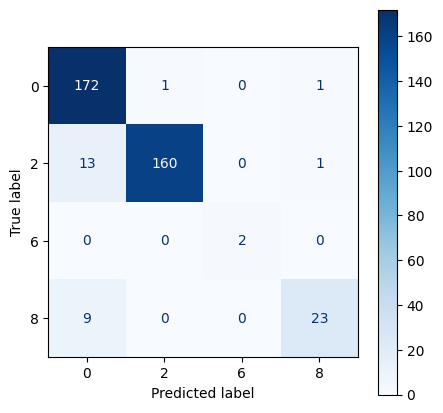

In [155]:
knn_model = KNeighborsClassifier(n_jobs=-1)

knn_model.fit(X_train, y_train)

y_predicted = knn_model.predict(X_test)

c = confusion_matrix(y_test, y_predicted)
print(c)

evaluation_classifier(y_test, y_predicted)
plot_confusion_matrix(c, knn_model)

In [156]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

n_neighbors = list(range(1, 10, 2))

p = list(range(2, 11, 4))
metric = ['euclidean', 'manhattan', 'chebyshev']
n_jobs = [-1]

param_grid = dict(
    n_neighbors = n_neighbors,
    p = p,
    metric = metric,
    n_jobs = n_jobs
)

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=-1, cv=cv, verbose=1, scoring='accuracy', refit=True)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 2 folds for each of 45 candidates, totalling 90 fits
0.942295057154553
{'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 1, 'p': 2}


In [173]:
y_train.value_counts()

label
0    695
2    695
8    125
6     10
Name: count, dtype: int64

[[173   1   0   0]
 [  9 163   0   2]
 [  0   0   2   0]
 [  6   0   0  26]]
Accuracy:  0.9528795811518325
Precision [micro]:  0.9528795811518325
Precision [macro]:  0.9358836206896551
Sensitivity [micro]:  0.9528795811518325
Sensitivity [macro]:  0.9606716583883164
F score [micro]:  0.9528795811518325
F score [macro]:  0.9467412032647902
Precision [all]:  [0.99425287 0.93678161 1.         0.8125    ]
F score [all]:  [0.9558011  0.96449704 1.         0.86666667]
Sensitivity [all]:  [0.92021277 0.99390244 1.         0.92857143]


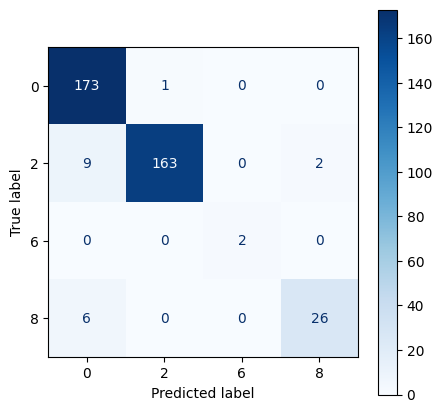

In [174]:
# {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 1, 'p': 2}

knn_model = KNeighborsClassifier(n_jobs=-1, metric='euclidean', n_neighbors=1, p=2)

knn_model.fit(X_train, y_train)

y_predicted = knn_model.predict(X_test)

c = confusion_matrix(y_test, y_predicted)
print(c)
evaluation_classifier(y_test, y_predicted)
plot_confusion_matrix(c, knn_model)

#### Neural Network

In [182]:
from sklearn.neural_network import MLPClassifier

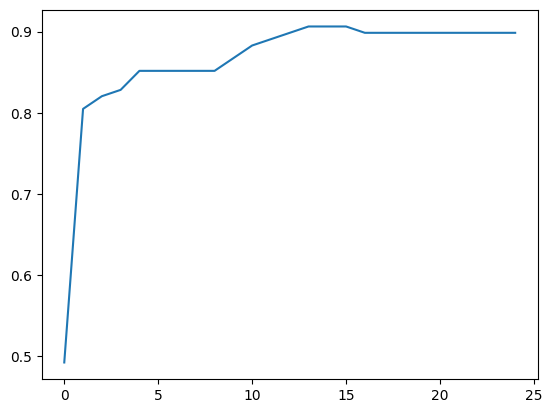

0.8930817610062893


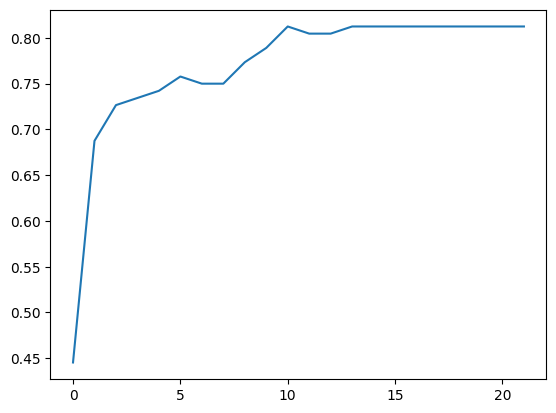

0.8820754716981132


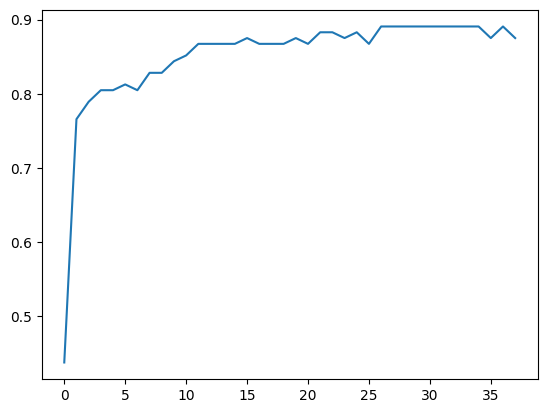

0.8818897637795275


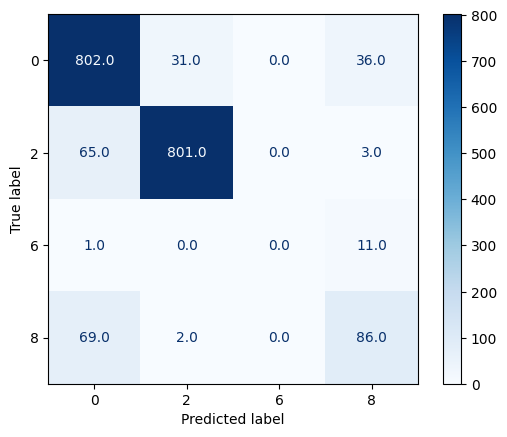

% correct predicted:  0.8856843209229156


In [187]:
s_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
indexes = s_kfold.split(X, y)

accuracy = []
final_confusion_matrix = np.zeros((len(np.unique(y)), len(np.unique(y))))

for train_index, test_index in indexes:
    classifier = MLPClassifier(hidden_layer_sizes=(64, 64, 64), activation='tanh',
                            solver='adam', batch_size=50, learning_rate='constant',
                            learning_rate_init=0.0001, max_iter=50, shuffle=True,
                            random_state=42, early_stopping=True, n_iter_no_change=10,
                            validation_fraction=0.1, verbose=False)

    classifier.fit(X.iloc[train_index, :].values, y.iloc[train_index])
    y_predicted = classifier.predict(X.iloc[test_index, :].values)
    plt.figure
    plt.plot(classifier.validation_scores_)
    plt.show()
    print(accuracy_score(y.iloc[test_index], y_predicted))
    final_confusion_matrix += confusion_matrix(y.iloc[test_index], y_predicted)

conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=final_confusion_matrix, display_labels=classifier.classes_)
conf_mat_display.plot(cmap='Blues', values_format='')
plt.show()

print("% correct predicted: ", sum(np.diag(final_confusion_matrix)) / sum(sum(final_confusion_matrix)))

In [214]:
X_test.shape

(1752, 20)

In [ ]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

hidden_layer_sizes = [(64, 64, 64), (32, 32, 32), (16, 32, 64), (12, 12, 12), (64, 32, 16, 8, 16, 32, 64)]
activation = ['relu', 'tanh']
solver = ['adam']
batch_size = [50, 80, 130]
learning_rate = ['constant', 'adaptive']
learning_rate_init = [0.001, 0.0005, 0.00001, 0.1]
early_stopping = [True]
shuffle = [True]
max_iter = [50, 100]
n_iter_no_change = [15]
validation_fraction = [0.1]
random_state = [42]

param_grid = dict(hidden_layer_sizes = hidden_layer_sizes,
                  activation = activation,
                  solver = solver,
                  batch_size = batch_size,
                  learning_rate = learning_rate,
                  learning_rate_init = learning_rate_init,
                  early_stopping = early_stopping,
                  shuffle = shuffle,
                  max_iter = max_iter,
                  n_iter_no_change = n_iter_no_change,
                  validation_fraction = validation_fraction,
                  random_state = random_state)


grid = GridSearchCV(MLPClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, refit=True, cv=cv, verbose=1)
grid.fit(X_train.values, y_train)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)


In [216]:
"""
Best params:  
    {'activation': 'relu', 
    'batch_size': 80, 
    'early_stopping': True, 
    'hidden_layer_sizes': (64, 64, 64), 
    'learning_rate': 'constant', 
    'learning_rate_init': 0.001, 
    'max_iter': 50, 
    'n_iter_no_change': 15, 
    'random_state': 42, 
    'shuffle': True, 
    'solver': 'adam', 
    'validation_fraction': 0.1}
    
Best score:  0.9882990867579908
"""

"\nBest params:  \n    {'activation': 'relu', \n    'batch_size': 80, \n    'early_stopping': True, \n    'hidden_layer_sizes': (64, 64, 64), \n    'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 50, 'n_iter_no_change': 15, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'validation_fraction': 0.1}\nBest score:  0.9882990867579908\n"

In [217]:
params = {'activation': 'relu', 
    'batch_size': 80, 
    'early_stopping': True, 
    'hidden_layer_sizes': (64, 64, 64), 
    'learning_rate': 'constant', 
    'learning_rate_init': 0.001, 
    'max_iter': 50, 
    'n_iter_no_change': 15, 
    'random_state': 42, 
    'shuffle': True, 
    'solver': 'adam', 
    'validation_fraction': 0.1}

In [227]:
model = MLPClassifier(**params, verbose=False)

In [228]:
model.fit(X_train, y_train)

MLPClassifier(batch_size=80, early_stopping=True,
              hidden_layer_sizes=(64, 64, 64), max_iter=50, n_iter_no_change=15,
              random_state=42)

In [229]:
y_predicted = model.predict(X_test)

In [230]:
confusion_matrix(y_test, y_predicted)

array([[ 168,    3,    4],
       [  10, 1545,    4],
       [   0,    0,   18]])

In [232]:
evaluation_classifier(y_predicted, y_test)

Accuracy:  0.988013698630137
Precision [micro]:  0.988013698630137
Precision [macro]:  0.8780633108435566
Sensitivity [micro]:  0.988013698630137
Sensitivity [macro]:  0.9836732948471242
F score [micro]:  0.988013698630137
F score [macro]:  0.921517220674474
Precision [all]:  [0.94382022 0.99806202 0.69230769]
F score [all]:  [0.95184136 0.99452848 0.81818182]
Sensitivity [all]:  [0.96       0.99101988 1.        ]


[[ 168    3    4]
 [  10 1545    4]
 [   0    0   18]]


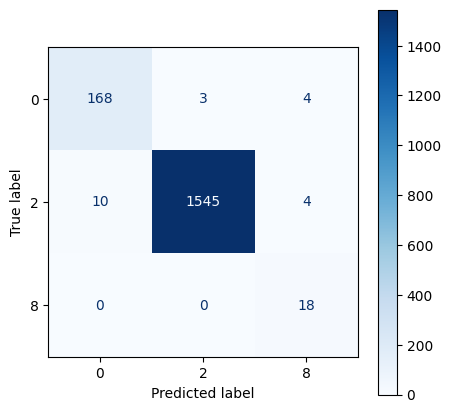

In [233]:
c = confusion_matrix(y_test, y_predicted)
print(c)

plot_confusion_matrix(c, model)

### Testing saved model

In [23]:
df = pd.read_csv(f'{DATA_PATH}/test_data.csv')

with open(f'{MODEL_PATH}/model.pkl', 'rb') as file:
    model = pickle.load(file)

In [24]:
y_test = df['label']

In [25]:
y_predicted = model.predict(df.drop('label', axis=1))

No resampling:
Accuracy:  0.9868721461187214
Precision [micro]:  0.9868721461187214
Precision [macro]:  0.9649789029535865
Sensitivity [micro]:  0.9868721461187214
Sensitivity [macro]:  0.8361917519183611
F score [micro]:  0.9868721461187214
F score [macro]:  0.8751373753882978
Precision [all]:  [0.9        0.99493671 1.        ]
F score [all]:  [0.94076655 0.99714558 0.6875    ]
Sensitivity [all]:  [0.98540146 0.99936427 0.52380952]

Resampled data:


In [26]:
evaluation_classifier(y_predicted, y_test)

Accuracy:  0.9763779527559056
Precision [micro]:  0.9763779527559056
Precision [macro]:  0.3333333333333333
Sensitivity [micro]:  0.9763779527559056
Sensitivity [macro]:  0.32545931758530183
F score [micro]:  0.9763779527559056
F score [macro]:  0.3293492695883134
Precision [all]:  [0. 1. 0.]
F score [all]:  [0.         0.98804781 0.        ]
Sensitivity [all]:  [0.         0.97637795 0.        ]


/home/stefan/Documents/Workspace/Python/ML/Hackathon/eco-forecast/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/Documents/Workspace/Python/ML/Hackathon/eco-forecast/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
